# Arabic Sign Language Recognition using a Neural Network

## Introduction

This notebook details the implementation of a neural network using PyTorch to recognize Arabic Sign Language alphabets.  The goal is to contribute to improving accessibility and communication for those who use sign language.

## 1. Dataset Details: ArASL

This project utilizes the ArASL (Arabic Alphabets Sign Language Dataset).  This dataset contains images of hand signs representing the Arabic alphabet.

- **Total Images:** 54,049
- **Classes:** 32 (representing the Arabic alphabet)

## 2. Dataset Split

The dataset has been split into training and validation sets:

- **Training Set Size:** 43,239 images
- **Validation Set Size:** 10,810 images

## 3. Label Representation

Each image is associated with a numerical label representing a specific Arabic character.  These labels are integers ranging from 0 to 31.

## 4. Character Mapping

The mapping between numerical labels and corresponding Arabic characters is defined in the `mapping` variable (see code).  The mapping is also provided below for reference:

0: 'seen', 1: 'zay', 2: 'aleff', 3: 'dal', 4: 'ta', 5: 'yaa', 6: 'fa', 7: 'ya', 8: 'khaa', 9: 'nun', 10: 'ha', 11: 'toot', 12: 'taa', 13: 'ra', 14: 'kaaf', 15: 'jeem', 16: 'laam', 17: 'la', 18: 'dhad', 19: 'dha', 20: 'waw', 21: 'meem', 22: 'al', 23: 'sheen', 24: 'haa', 25: 'thaa', 26: 'saad', 27: 'ghain', 28: 'ain', 29: 'thal', 30: 'gaaf', 31: 'bb'

## 5. Reference

Latif, G., Mohammad, N., Alghazo, J., AlKhalaf, R., & AlKhalaf, R. (2019). ARASL: Arabic Alphabets Sign Language Dataset. *Data in Brief*, 23, 103777. https://doi.org/10.1016/j.dib.2019.103777

In [3]:
from IPython.display import clear_output

In [4]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [5]:
# importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

## Downloading the dataset

### Run the following cells to download the MNIST dataset.

In [6]:
!gdown https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded

Downloading...
From: https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded
To: /content/file_downloaded
100% 66.2M/66.2M [00:02<00:00, 25.8MB/s]


In [7]:
import os

def delete_folder(folder_path):
    try:
        # Get the list of files and subdirectories in the folder
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # If it's a file, delete it
            if os.path.isfile(item_path):
                os.remove(item_path)
            # If it's a directory, recursively call delete_folder
            elif os.path.isdir(item_path):
                delete_folder(item_path)

        # Remove the empty folder
        os.rmdir(folder_path)
        print(f"Folder '{folder_path}' and its contents deleted successfully.")
    except FileNotFoundError:
        print(f"Folder '{folder_path}' not found.")
    except PermissionError:
        print(f"Permission error: Unable to delete folder '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")


delete_folder('ArASL_Database_54K_Final')

!unzip file_downloaded
clear_output()

### If you will build the neural network using numpy, change `t`'s value to 28. If you will build the neural network using pytorch, change `t`'s vlaue to 48. `t`'s value represents the size of the image.

In [ ]:
t = 48

## Just run these two cells. You are not supposed to explore them.

In [8]:
import os

def rename_folders_and_create_mapping(folder_path):
    # Get the list of folders in the specified path
    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    # Create a mapping from original folder names to numbers
    folder_mapping = {folder: i for i, folder in enumerate(folders)}

    # Rename the folders in-place and store the original names in the mapping
    for original_folder, number in folder_mapping.items():
        new_folder_name = str(number)
        new_folder_path = os.path.join(folder_path, new_folder_name)

        # Rename the folder
        os.rename(os.path.join(folder_path, original_folder), new_folder_path)

    return folder_mapping

folder_path = 'ArASL_Database_54K_Final'

# Create the folder mapping and rename folders
mapping = rename_folders_and_create_mapping(folder_path)

# Print the folder mapping
print("Folder Mapping:")
print(mapping)


Folder Mapping:
{'taa': 0, 'la': 1, 'ya': 2, 'yaa': 3, 'ghain': 4, 'ta': 5, 'kaaf': 6, 'dal': 7, 'bb': 8, 'ra': 9, 'waw': 10, 'laam': 11, 'thal': 12, 'fa': 13, 'seen': 14, 'khaa': 15, 'zay': 16, 'nun': 17, 'meem': 18, 'dhad': 19, 'ain': 20, 'sheen': 21, 'toot': 22, 'jeem': 23, 'ha': 24, 'al': 25, 'thaa': 26, 'gaaf': 27, 'saad': 28, 'dha': 29, 'haa': 30, 'aleff': 31}


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(28, 28)):
        self.root_folder = root_folder
        self.transform = transform
        self.target_size = target_size

        # Get the list of image files
        self.image_files = []
        self.image_labels = []

        for root, dirs, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))
                    self.image_labels.append(int(os.path.basename(root)))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.image_labels[idx]

        # Convert label to tensor
        # print("Label", label, type(label))
        label = torch.tensor(label)

        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')

            # Resize the image
            img = img.resize(self.target_size)

            # Apply additional transformations if specified
            if self.transform:
                img = self.transform(img)

            return (img, label)

# Define the root folder and output folder
root_folder_path = 'ArASL_Database_54K_Final'


# Define transformations (resize to 28x28 and convert to tensor)
data_transform = transforms.Compose([

    transforms.Resize((t, t)),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_folder_path, transform=data_transform)

from torch.utils.data import random_split

# Define the size of the training and validation sets
total_size = len(custom_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

mapping = {v:k for k,v in mapping.items()}

## Exploring the data

#### Here is the mapping for each class and its encoding. In addition to the train_dataset and val_dataset

In [10]:
train_dataset # Contains the training ArASL_Database_54K_Final dataset (80%)

val_dataset  # Contains the validating ArASL_Database_54K_Final dataset (20%)


print("The mapping between the letters and the encoding: \n", mapping)

# Check the lengths of train_dataset and val_dataset.
len(train_dataset), len(val_dataset)

The mapping between the letters and the encoding: 
 {0: 'taa', 1: 'la', 2: 'ya', 3: 'yaa', 4: 'ghain', 5: 'ta', 6: 'kaaf', 7: 'dal', 8: 'bb', 9: 'ra', 10: 'waw', 11: 'laam', 12: 'thal', 13: 'fa', 14: 'seen', 15: 'khaa', 16: 'zay', 17: 'nun', 18: 'meem', 19: 'dhad', 20: 'ain', 21: 'sheen', 22: 'toot', 23: 'jeem', 24: 'ha', 25: 'al', 26: 'thaa', 27: 'gaaf', 28: 'saad', 29: 'dha', 30: 'haa', 31: 'aleff'}


(43239, 10810)

In [11]:
batch_size = 64

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Do Not shuffle validation data

In [18]:
next(iter(train_loader))[0].shape

torch.Size([64, 1, 48, 48])

## Let's visualize an image.

The image label: 5 ta


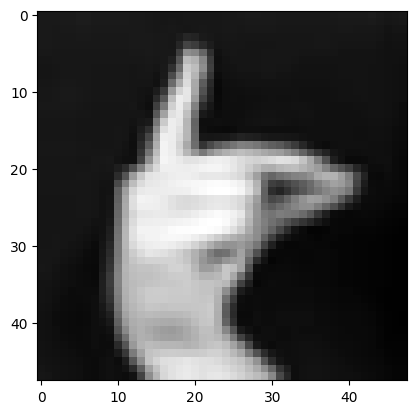

In [16]:
random_img_idx = 30 # Write any random index (between 0 and 59999)

image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
label = train_dataset[random_img_idx][1]  # 1 for label part

print("The image label:", label.item(), mapping[label.item()])

plt.imshow(image.reshape(image.shape[1], image.shape[1]), cmap='gray')

### Instructions:

- Create a Neural Network: Use either PyTorch or NumPy to construct your neural network (NN).
- Train the Model: Once the network is defined, proceed to train the model with the data.
- Experiment with Layers: Adjust and experiment with different layer configurations to optimize the model's performance. Aim to achieve at least 80% accuracy on the validation dataset. Make sure to include a minimum of three distinct layers.
- Explore Activation Functions: Try out various activation functions to find the most effective combination for your network.